# QAOA

## Introdução

Quantum Approximate Optimization Algorithm.

O termo "aproximado" significa que existem certos parâmetros que são usados no algortimo e quanto melhor tais parâmetros melhor a solução.

- Artigo original: https://arxiv.org/abs/1411.4028
- Video: https://www.youtube.com/watch?v=-oeP7Rz8JsU


QAOA é um algoritmo que produz soluções aproximadas para problemas de otimização combinatorial. O algoritmo depende de um inteiro $p \geq 1$ e a qualidade da aproximação aumenta a medida que $p$ aumenta.

Um problema de otimização combinatória pode ser entendido como um problema específicado por $n$ bits e $m$ cláusulas tal que se $z=z_{n-1}z_{n-2}\dotso z_0$ é uma cadeia de $n$ bits a função objetivo $C$ é dada por

$$
C(z) = \sum_{\alpha = 1}^m C_\alpha(z)
$$

De modo que $C_\alpha(z)=1$ se $z$ satisfaz a cláusula $\alpha$ e 0 caso contrário.

A otimização aproximada é a tarefa de encontrar $z$ para qual $C(z)$ é próximo do máximo da função objetivo $C$.


Computadores quânticos atuam em um espaço de Hilbert de dimensão $2^n$ com vetores $\ket{z}$ da base computacional. Podemos ver $C(z)$ como um operador diagonal na base computacional. Definimos

$$
C = \sum_z C(z)\ket{z}\bra{z}
$$

e

$$
C\ket{z} = C(z)\ket{z}
$$

Portanto, os estados $\ket{z}$ são autovetores de $C$ e os autovalores são os custos $C(z)$.

Vamos definir o operador unitário $U(C,\gamma)$, que depende do ângulo $\gamma$, como

$$
U(C,\gamma) = e^{-i\gamma C} = \Pi_{\alpha=1}^m e^{-i\gamma C_\alpha}
$$

## Maxcut

In [11]:
import rustworkx as rx
from rustworkx.visualization import mpl_draw as draw_graph
import sympy as sp
import IPython.display as disp
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister, transpile
import numpy as np
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram
from scipy.optimize import differential_evolution

Considere o grafo dado pelo código abaixo

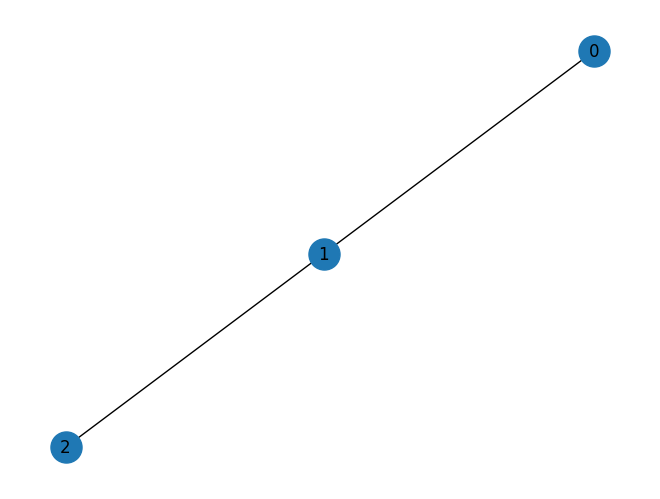

In [12]:
num_vertices = 3
graph_edge_list = [
    (0, 1, 1.0),
    (1, 2, 1.0),
]

num_edges = len(graph_edge_list)
 
graph = rx.PyGraph()
graph.add_nodes_from(np.arange(0, num_vertices, 1))

graph.add_edges_from(graph_edge_list)
draw_graph(graph, node_size=500, with_labels=True)

Para o problema do maxcut temos

$$
C = \sum_{(i,j)\in E} \frac{1}{2}(I-Z_iZ_j) = I -\frac{1}{2}(Z_0Z_1 + Z_1Z_2)
$$

onde

- $Z_0Z_1 = I\otimes Z_1\otimes Z_0$
- $Z_1Z_2 = Z_2\otimes Z_1\otimes I$


Ao definirmos os estados base $\ket{z_2z_1z_0}, z_k\in\{0,1\}$ obtemos

$$
C(z) = \frac{1}{2}(1 - (-1)^{z_0\oplus z_1}) + \frac{1}{2}(1 - (-1)^{z_1\oplus z_2})
$$

onde $\oplus$ denota a adição módulo 2 e que produz a seguinte tabela

$$
\begin{array}{c|c}
z = z_2 z_1 z_0 & C(z) \\
\hline
000 & 0 \\
001 & 1 \\
010 & 2 \\
011 & 1 \\
100 & 1 \\
101 & 2 \\
110 & 1 \\
111 & 0 \\
\end{array}
$$

Explicitamente $C$ pode ser visto como a matriz

$$
C =
\begin{pmatrix}
0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 \\
0 & 1 & 0 & 0 & 0 & 0 & 0 & 0 \\
0 & 0 & 2 & 0 & 0 & 0 & 0 & 0 \\
0 & 0 & 0 & 1 & 0 & 0 & 0 & 0 \\
0 & 0 & 0 & 0 & 1 & 0 & 0 & 0 \\
0 & 0 & 0 & 0 & 0 & 2 & 0 & 0 \\
0 & 0 & 0 & 0 & 0 & 0 & 1 & 0 \\
0 & 0 & 0 & 0 & 0 & 0 & 0 & 0
\end{pmatrix}.
$$

Calculando $U(C, \gamma)$ temos

$$
U(C,\gamma) = e^{-i\gamma C} = \Pi_{\alpha=1}^m e^{-i\gamma C_\alpha} = U(C,\gamma) =
\begin{pmatrix}
1 & 0 & 0 & 0 & 0 & 0 & 0 & 0 \\
0 & e^{-i\gamma} & 0 & 0 & 0 & 0 & 0 & 0 \\
0 & 0 & e^{-i2\gamma} & 0 & 0 & 0 & 0 & 0 \\
0 & 0 & 0 & e^{-i\gamma} & 0 & 0 & 0 & 0 \\
0 & 0 & 0 & 0 & e^{-i\gamma} & 0 & 0 & 0 \\
0 & 0 & 0 & 0 & 0 & e^{-i2\gamma} & 0 & 0 \\
0 & 0 & 0 & 0 & 0 & 0 & e^{-i\gamma} & 0 \\
0 & 0 & 0 & 0 & 0 & 0 & 0 & 1
\end{pmatrix}
$$

que pode ser implementado em qiskit como a função

In [13]:
def cost_layer(qc: QuantumCircuit, gamma: float, edges: list):
    """U(C, gamma) implementado como CX-RZ(2*gamma)-CX."""
    for i, j in edges:
        qc.cx(i, j)
        qc.rz(2*gamma, j)   # exp(-i*gamma*Z_i Z_j)
        qc.cx(i, j)

Considere agora o operador

$$
B = \sum_{j=1}^n X_j
$$

e o operador $U(B, \beta)$ dado por

$$
U(B, \beta) = e^{-i\beta B} = \Pi_{j=1} e^{-i\beta X_j} = \bigotimes R_x(2\beta)
$$

com $\beta \in [0, \pi]$.

Podemos implementar $U(B, \beta)$ da seguinte forma

In [14]:
def mixer_layer(qc: QuantumCircuit, beta: float):
    """U(B, beta) = Rx(2*beta) em cada qubit"""
    for q in range(qc.num_qubits):
        qc.rx(2*beta, q)

O estado inicial $\ket{s}$ é dado pela superposição uniforme nos estados da base computacional

$$
\ket{s} = \frac{1}{\sqrt{2^n}} \sum_z \ket{z}.
$$

Com ambas as funções podemos construir o bloco do algoritmo QAOA

In [15]:
def qaoa_block(n_qubits: int, edges: list, gamas: list, betas: list):
    p = len(gamas)
    qc = QuantumCircuit(n_qubits)

    qc.h(range(n_qubits))
    qc.barrier()

    for l in range(p):
        gamma_l = gamas[l]
        beta_l = betas[l]
        cost_layer(qc, gamma_l, edges)
        qc.barrier()
        mixer_layer(qc, beta_l)
        qc.barrier()

    qc.measure_all()

    return qc

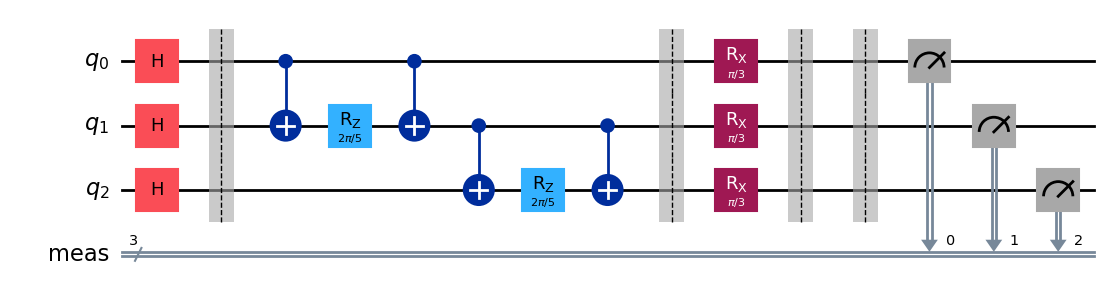

In [16]:
n = 3
edges = [(0,1), (1,2)]
gammas = [np.pi/5]
betas = [np.pi/6]
p = len(gammas)

qc = qaoa_block(n, edges, gammas, betas)
qc.draw(output="mpl", style="iqp")

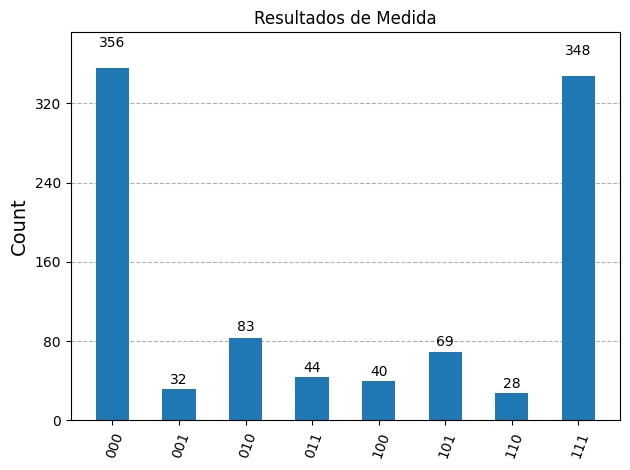

In [17]:
sim = AerSimulator()
tqc = transpile(qc, sim)
result = sim.run(tqc, shots=1000).result()
counts = result.get_counts()

plot_histogram(counts, title='Resultados de Medida')

Observe que o resultado obtido não é o esperado. Isto ocorre pois a escolha dos parâmetros $\gamma$ e $\beta$ não pode ser arbitrária estes parâmetros devem ser otimizados.

O código abaixo, assumindo $p=1$ busca pelos parâmetros adequados.

In [18]:
def cut_value(z: list, edges: list):
    cut_value = 0
    for (i, j) in edges:
        if z[i] != z[j]:
            cut_value += 1

    return cut_value

def expected_cut(counts, edges: list):
    shots = sum(counts.values())

    exp_cut = 0
    for z, z_count in counts.items():
        exp_cut += cut_value(z, edges) * z_count/shots

    return exp_cut

def calc_cut(n_qubits: int, edges: list, gammas: list, betas: list):
    qc = qaoa_block(n_qubits, edges, gammas, betas)
    tqc = transpile(qc, sim)
    counts = sim.run(tqc, shots=1000).result().get_counts()

    return -expected_cut(counts, edges)

def qaoa_bounds(p: int):
    bounds = []
    for _ in range(p):
        bounds.append((0, 2*np.pi))
    for _ in range(p):
        bounds.append((0, np.pi))
    return bounds

In [19]:
bounds = qaoa_bounds(p)

result = differential_evolution(
    func=lambda params: calc_cut(
        n_qubits=qc.num_qubits,
        edges=edges,
        gammas=params[:p].tolist(),
        betas=params[p:].tolist()
    ),
    bounds=bounds,
    maxiter=50,
    popsize=10,
    tol=1e-2,
    polish=True
)

best_params = {"val": -result.fun, "params": result.x}
print(f"val: {best_params["val"]}, params:{best_params["params"]}")

val: 1.6780000000000002, params:[3.67229889 1.17090413]


Aplicando os valores otimizados

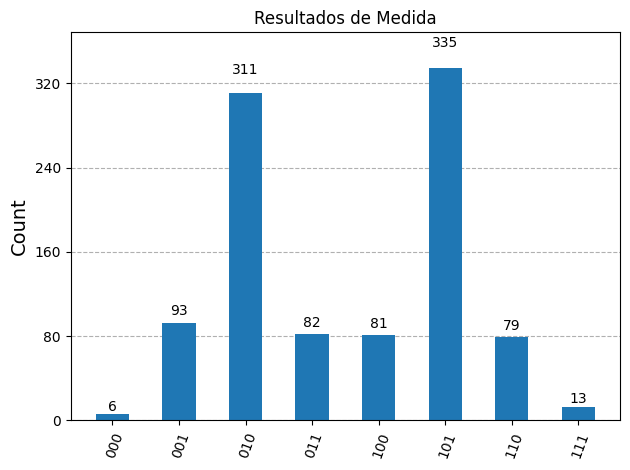

In [20]:
params = best_params["params"]
qc = qaoa_block(n, edges, params[0:p], params[p:])

sim = AerSimulator()
tqc = transpile(qc, sim)
result = sim.run(tqc, shots=1000).result()
counts = result.get_counts()

plot_histogram(counts, title='Resultados de Medida')